In [42]:
from keras.datasets import cifar10, mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, add, Dense, Dropout, Dropout, BatchNormalization,ZeroPadding2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Short EDA for CIFAR-10

In [58]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [59]:
print('Shape of train_images is {}'.format(train_images.shape))
print('Shape of train_labels is {}'.format(train_labels.shape)) 
print('Shape of test_images is {}'.format(test_images.shape))
print('Shape of test_labels is {}'.format(test_labels.shape))

Shape of train_images is (50000, 32, 32, 3)
Shape of train_labels is (50000, 1)
Shape of test_images is (10000, 32, 32, 3)
Shape of test_labels is (10000, 1)


## <span style="color: #8B0000;">Reshaping images</span> 

In [64]:
#X_train = train_images.reshape((50000, 32 * 32 *3))
X_train = train_images.astype('float32') / 255
#X_test = test_images.reshape((10000, 32 * 32 *3))
X_test = test_images.astype('float32') / 255

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (50000, 32, 32, 3)
Shape y_train: (50000, 10)
Shape X_test: (10000, 32, 32, 3)
Shape y_test: (10000, 10)


## <span style="color: #8B0000;">CIFAR-10 dataset contains 10 different picture classes.</span> 

In [65]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

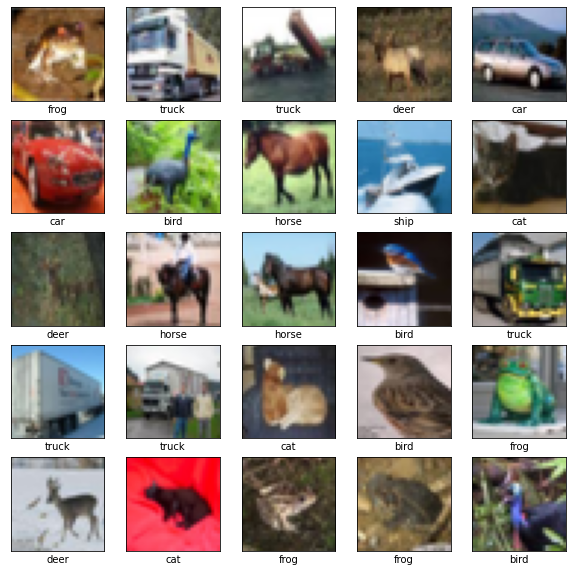

In [66]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[train_labels[i][0]])
plt.show()

## <span style="color: #8B0000;">Number of unique values in each class - classes are equally distributed</span> 

In [67]:
unique, counts = np.unique(train_labels, return_counts=True)
train_count = pd.DataFrame({'Class': classes, 'Count': counts})
train_count

,Class,Count
0,plane,5000
1,car,5000
2,bird,5000
3,cat,5000
4,deer,5000
5,dog,5000
6,frog,5000
7,horse,5000
8,ship,5000
9,truck,5000


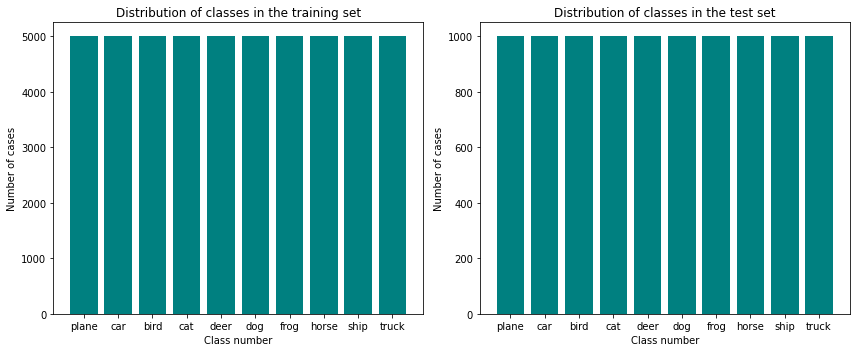

In [68]:
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(classes, counts_train, color="teal")
axs[0].set_title('Distribution of classes in the training set')
axs[0].set_xlabel('Class number')
axs[0].set_ylabel('Number of cases')
axs[0].set_xticks(unique_train)

axs[1].bar(classes, counts_test, color="teal")
axs[1].set_title('Distribution of classes in the test set')
axs[1].set_xlabel('Class number')
axs[1].set_ylabel('Number of cases')
axs[1].set_xticks(unique_test)

plt.tight_layout()
plt.show()

## <span style="color: #8B0000;">Histograms divided by pixel colour</span> 

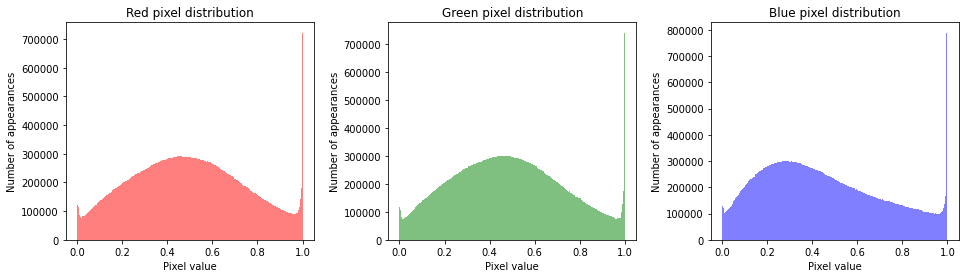

In [69]:
X_train_flattened = X_train.flatten()

red_pixels = X_train_flattened[::3]  # Red
green_pixels = X_train_flattened[1::3]  # Green
blue_pixels = X_train_flattened[2::3]  # Blue

fig, axs = plt.subplots(1, 3, figsize=(16, 4))


axs[0].hist(red_pixels, bins=255, color='red', alpha=0.5, label='Red')
axs[0].set_xlabel("Pixel value")
axs[0].set_ylabel("Number of appearances")
axs[0].set_title("Red pixel distribution")

axs[1].hist(green_pixels, bins=255, color='green', alpha=0.5, label='Green')
axs[1].set_xlabel("Pixel value")
axs[1].set_ylabel("Number of appearances")
axs[1].set_title("Green pixel distribution")

axs[2].hist(blue_pixels, bins=255, color='blue', alpha=0.5, label='Blue')
axs[2].set_xlabel("Pixel value")
axs[2].set_ylabel("Number of appearances")
axs[2].set_title("Blue pixel distribution")

plt.subplots_adjust(wspace=0.3)
plt.show()

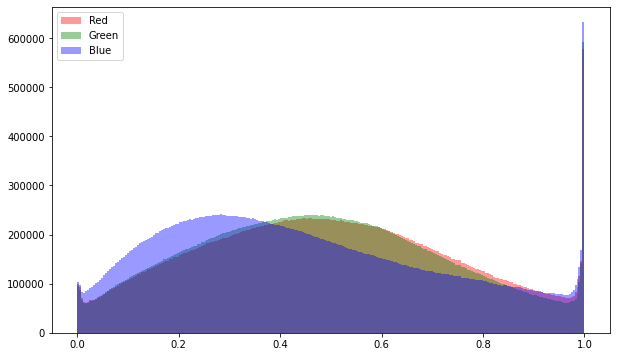

In [19]:
plt.figure(figsize=(10,6))
plt.hist(red_pixels, bins=255, color='red', alpha=0.4, label='Red')
plt.hist(green_pixels, bins=255, color='green', alpha=0.4, label='Green')
plt.hist(blue_pixels, bins=255, color='blue', alpha=0.4, label='Blue')
plt.legend()
plt.show()

# CONVOLUTIONAL NEURAL NETWORK 

- Warstwa konwolucyjna / splotowa (Convolutional Layers) - zawierają wyuczone filtry (kernele), które wyodrębniają cechy odróżniające od siebie różne obrazy
- Kernel Size (rozmiar jądra) - ozmiarem filtra, odnosi się do wymiarów przesuwanego okna nad wejściem
- Padding (wypełnienie) - posób obsługi obramowania próbki
- Strides (kroki) - o ile pikseli jądro powinno zostać przesunięte na raz
- Pooling Layers - stopniowe zmniejszanie rozmiaru obrazu, co zmniejsza liczbę parametrów do wytrenowania.

In [4]:
print('Shape of train_images is {}'.format(train_images.shape))
print('Shape of train_labels is {}'.format(train_labels.shape)) 
print('Shape of test_images is {}'.format(test_images.shape))
print('Shape of test_labels is {}'.format(test_labels.shape))

Shape of train_images is (50000, 32, 32, 3)
Shape of train_labels is (50000, 1)
Shape of test_images is (10000, 32, 32, 3)
Shape of test_labels is (10000, 1)


In [5]:
X_train = train_images.astype('float32') / 255
X_test = test_images.astype('float32') / 255

In [6]:
#X_train, _, train_labels, _ = train_test_split(X_train, train_labels, train_size=10000, stratify=train_labels, random_state=42)
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [7]:
print(X_train.shape)
print(train_labels.shape)
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

(50000, 32, 32, 3)
(50000, 1)
{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


# 1) model  - 1 convolutional layer and 1 pooling layer

In [8]:


model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=15, batch_size=64,
                     validation_split=0.2)
history_dict = history.history
with open('training_history1.json', 'w') as f:
    json.dump(history_dict, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 128)               1843328   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [90]:
def test_model(model, X_test, y_test, history_file, X_train, y_train):
    # Wczytanie historii z pliku tekstowego
    with open(history_file, 'r') as f:
        history = json.load(f)

    plt.figure(figsize=(12, 5)) 
    plt.subplot(1, 2, 1)  
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()  
    plt.show()

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy on test set: %.2f' % (test_acc * 100))
    
    train_loss, train_acc = model.evaluate(X_train, y_train)
    print('Accuracy on train set: %.2f' % (train_acc * 100))
    

In [89]:
def test_model(model, X_test, y_test, history_file, X_train, y_train):
    # Wczytanie historii z pliku tekstowego
    with open(history_file, 'r') as f:
        history = json.load(f)

    plt.figure(figsize=(12, 5)) 
    plt.subplot(1, 2, 1)  
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.subplot(1, 2, 2) 
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()  
    plt.show()

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy on test set: %.2f' % (test_acc * 100))
    
    train_loss, train_acc = model.evaluate(X_train, y_train)
    print('Accuracy on train set: %.2f' % (train_acc * 100))
    
test_model(model, X_test, y_test, 'training_history1.json', X_train, y_train)

NameError: name 'model' is not defined

# 2) model  - 2 convolutional layers and 1 pooling layer

In [10]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)

history_dict = history.history
with open('training_history2.json', 'w') as f:
    json.dump(history_dict, f)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 128)        

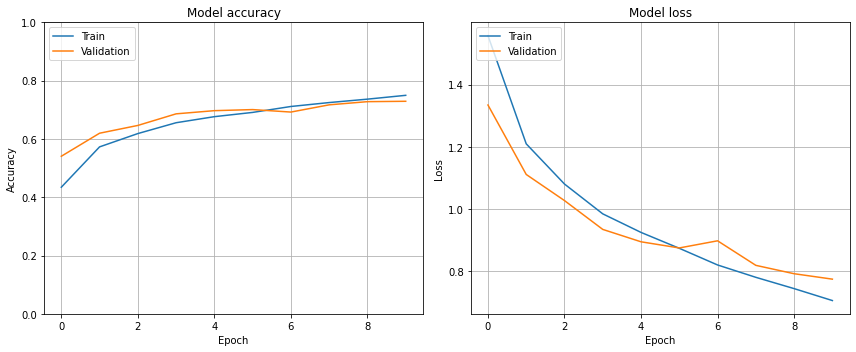

Accuracy on test set: 72.20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.5557 - accuracy: 0.8164
Accuracy on train set: 81.64


In [11]:
test_model(model, X_test, y_test, 'training_history2.json', X_train, y_train)

# 3) model - 2 cov 1poll + 2 cov 1poll

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 128)       147584    
                                                      

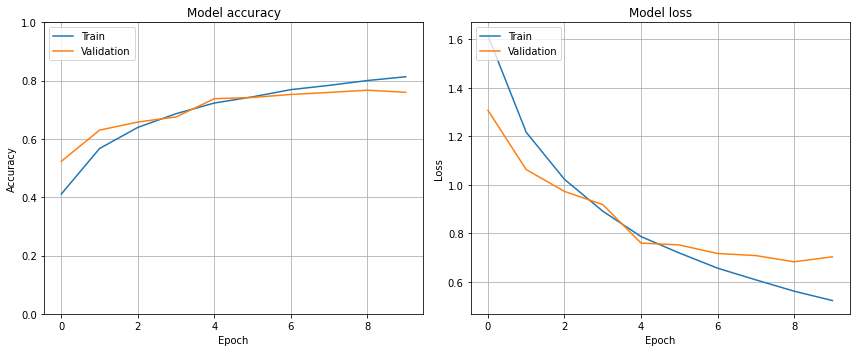

Accuracy on test set: 75.07
1563/1563 [==============================] - 69s 44ms/step - loss: 0.4382 - accuracy: 0.8522
Accuracy on train set: 85.22


In [12]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(128, kernel_size=(3, 3),  activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3),  activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))
 
model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2,verbose=0)

history_dict = history.history
with open('training_history3.json', 'w') as f:
    json.dump(history_dict, f)


test_model(model, X_test, y_test, 'training_history3.json', X_train, y_train)

# 4) 3 layers with 

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))   

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)

history_dict = history.history
with open('training_history4.json', 'w') as f:
    json.dump(history_dict, f)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

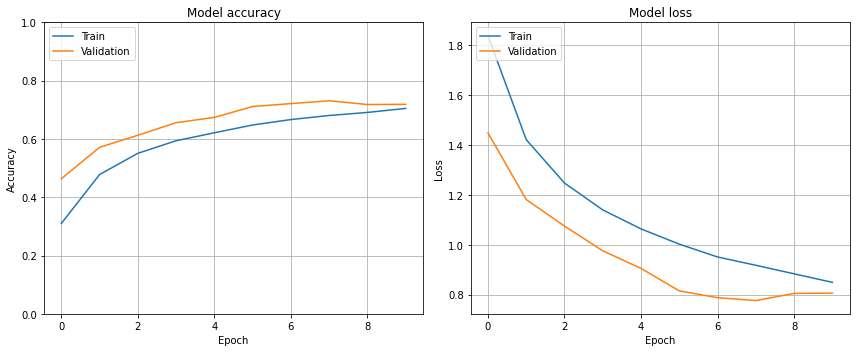

Accuracy on test set: 71.53
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7357 - accuracy: 0.7386
Accuracy on train set: 73.86


In [14]:
test_model(model, X_test, y_test, 'training_history4.json', X_train, y_train)

# 5) 3 layers with bath normalization

In [15]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))   

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)

history_dict = history.history
with open('training_history5.json', 'w') as f:
    json.dump(history_dict, f)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

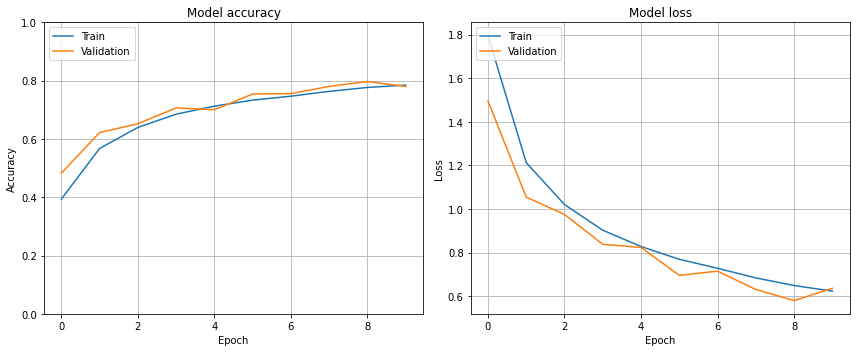

Accuracy on test set: 77.77
1563/1563 [==============================] - 72s 46ms/step - loss: 0.5340 - accuracy: 0.8126
Accuracy on train set: 81.26


In [16]:
test_model(model, X_test, y_test, 'training_history5.json', X_train, y_train)

# With and without dropout 

In [17]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)
          
history_dict = history.history
with open('training_history_out_drop.json', 'w') as f:
    json.dump(history_dict, f)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 128)              

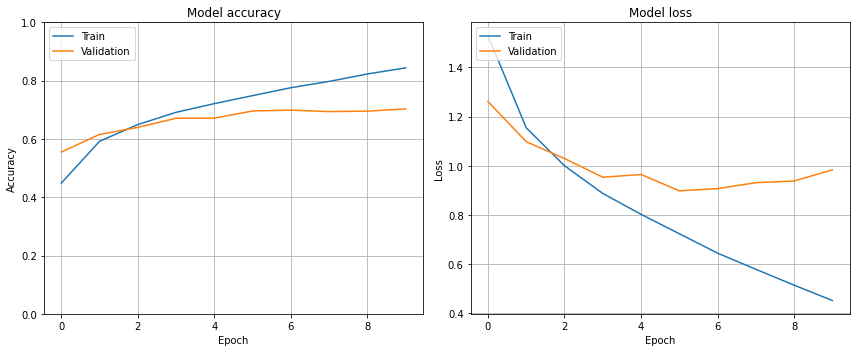

Accuracy on test set: 69.53
1563/1563 [==============================] - 26s 17ms/step - loss: 0.4845 - accuracy: 0.8451
Accuracy on train set: 84.51


In [18]:
test_model(model, X_test, y_test, 'training_history_out_drop.json', X_train, y_train)

In [19]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)
          
history_dict = history.history
with open('training_history_drop25.json', 'w') as f:
    json.dump(history_dict, f)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 6, 6, 128)        

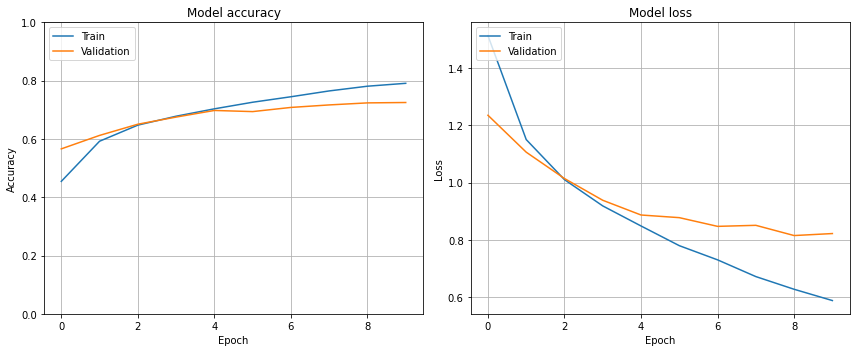

Accuracy on test set: 71.64
1563/1563 [==============================] - 26s 17ms/step - loss: 0.5002 - accuracy: 0.8365
Accuracy on train set: 83.65


In [20]:
test_model(model, X_test, y_test, 'training_history_drop25.json', X_train, y_train)

In [21]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2)
          
history_dict = history.history
with open('training_history_drop50.json', 'w') as f:
    json.dump(history_dict, f)          


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 6, 6, 128)        

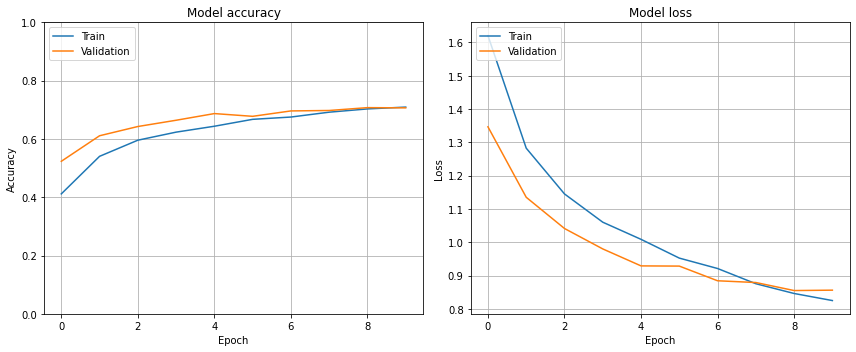

Accuracy on test set: 69.74
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7142 - accuracy: 0.7623
Accuracy on train set: 76.23


In [22]:
test_model(model, X_test, y_test, 'training_history_drop50.json', X_train, y_train)

# Batch size change

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 6, 6, 128)        

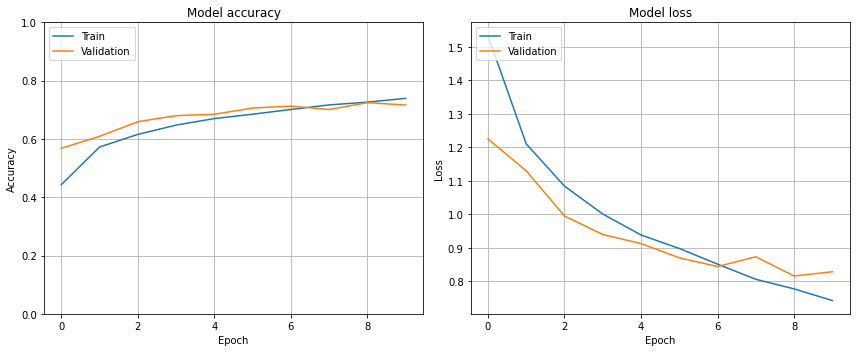

Accuracy on test set: 70.80
1563/1563 [==============================] - 30s 19ms/step - loss: 0.6031 - accuracy: 0.7976
Accuracy on train set: 79.76


In [23]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=32,
                     validation_split=0.2,verbose=0)
          
history_dict = history.history
with open('training_history_batch32.json', 'w') as f:
    json.dump(history_dict, f)
          
test_model(model, X_test, y_test, 'training_history_batch32.json', X_train, y_train)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 6, 6, 128)        

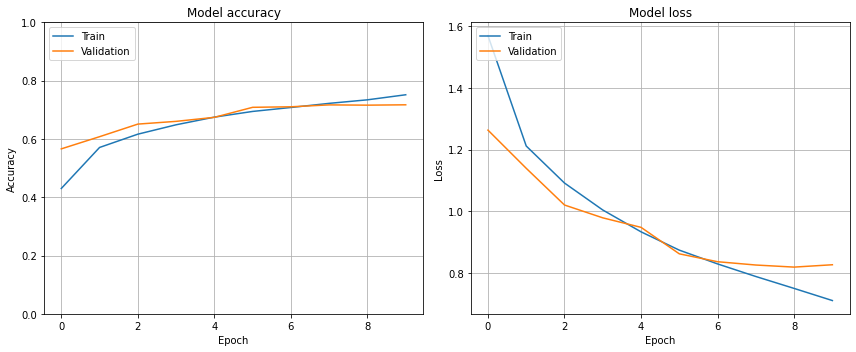

Accuracy on test set: 71.72
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6182 - accuracy: 0.8033
Accuracy on train set: 80.33


In [24]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=64,
                     validation_split=0.2,verbose=0)
          
history_dict = history.history
with open('training_history_batch64.json', 'w') as f:
    json.dump(history_dict, f)
          
test_model(model, X_test, y_test, 'training_history_batch64.json', X_train, y_train)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 6, 6, 128)       

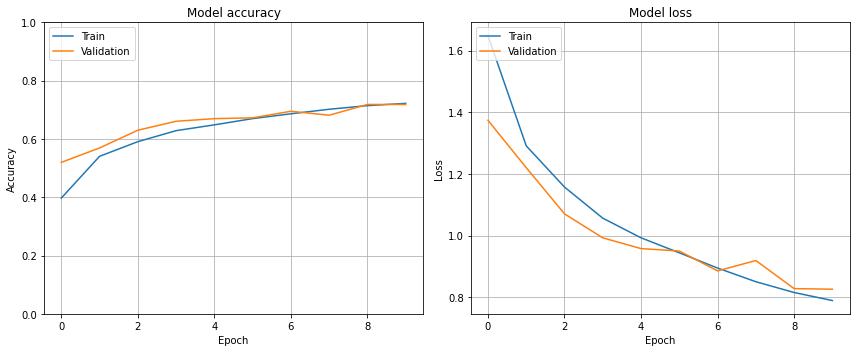

Accuracy on test set: 71.18
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6809 - accuracy: 0.7767
Accuracy on train set: 77.67


In [25]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                     epochs=10, batch_size=128,
                     validation_split=0.2,verbose=0)
          
history_dict = history.history
with open('training_history_batch128.json', 'w') as f:
    json.dump(history_dict, f)
          
test_model(model, X_test, y_test, 'training_history_batch128.json', X_train, y_train)

# Augmenting the images before using them in the CNN network and comparing them with the results without augmentations

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
X_train = train_images.astype('float32') / 255
X_test = test_images.astype('float32') / 255
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#train_datagen.fit(X_train)
#X_train.shape

In [12]:
import numpy as np

# Ustawienie wielkości batcha równego wielkości zbioru treningowego
batch_size = len(X_train)
augmented_images = []
augmented_labels = []

# Generowanie dokładnie dwóch zestawów augmentowanych obrazów
for _ in range(2):
    # Tworzenie iteratora
    iterator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=False)
    aug_images, aug_labels = next(iterator)
    augmented_images.append(aug_images)
    augmented_labels.append(aug_labels)

# Konwersja list na numpy arrays
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

X_train_augmented = np.concatenate([X_train, augmented_images])
y_train_augmented = np.concatenate([y_train, augmented_labels])

print("Nowy rozmiar zbioru treningowego (obrazy):", X_train_augmented.shape)
print("Nowy rozmiar zbioru treningowego (etykiety):", y_train_augmented.shape)

Nowy rozmiar zbioru treningowego (obrazy): (150000, 32, 32, 3)
Nowy rozmiar zbioru treningowego (etykiety): (150000, 10)


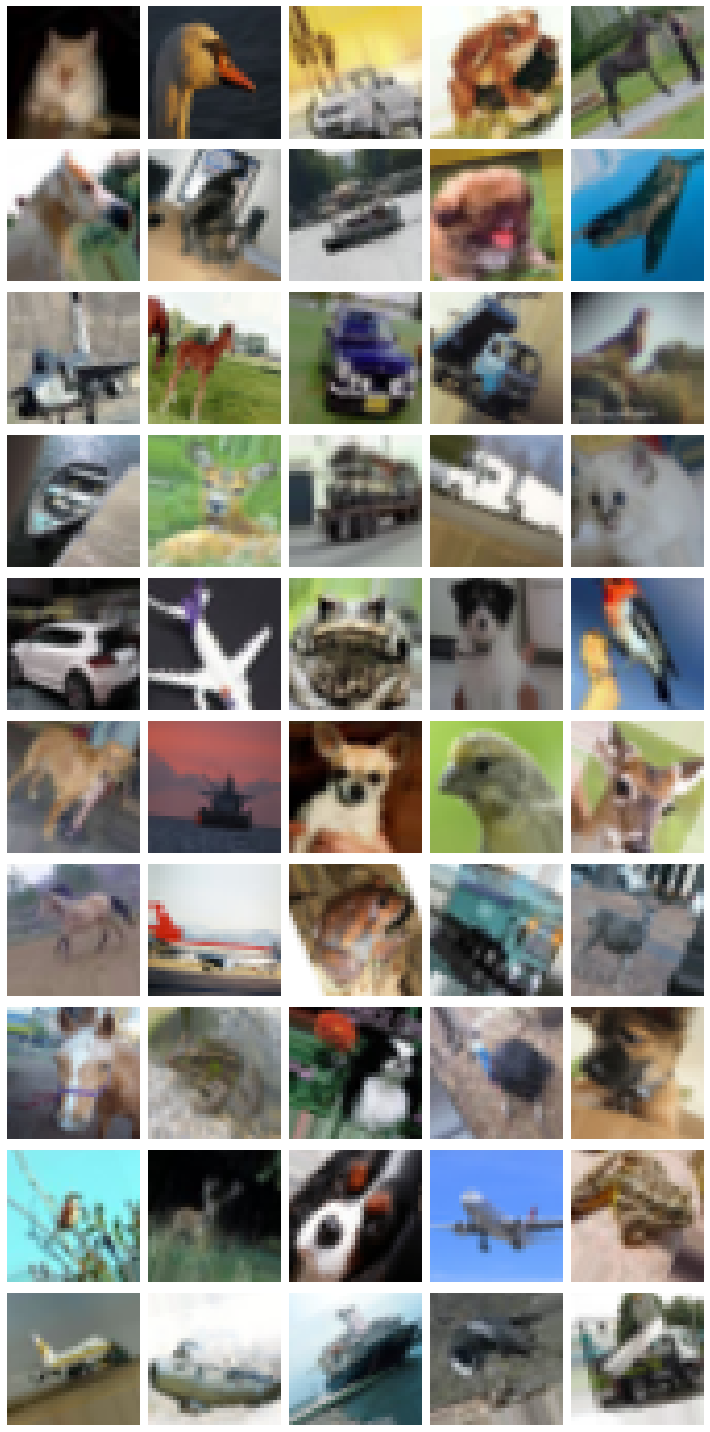

In [74]:
import matplotlib.pyplot as plt

def display_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off') 
    plt.tight_layout() 
    plt.show()

sample_images = augmented_images[:50]  

display_images(augmented_images, 10, 5)

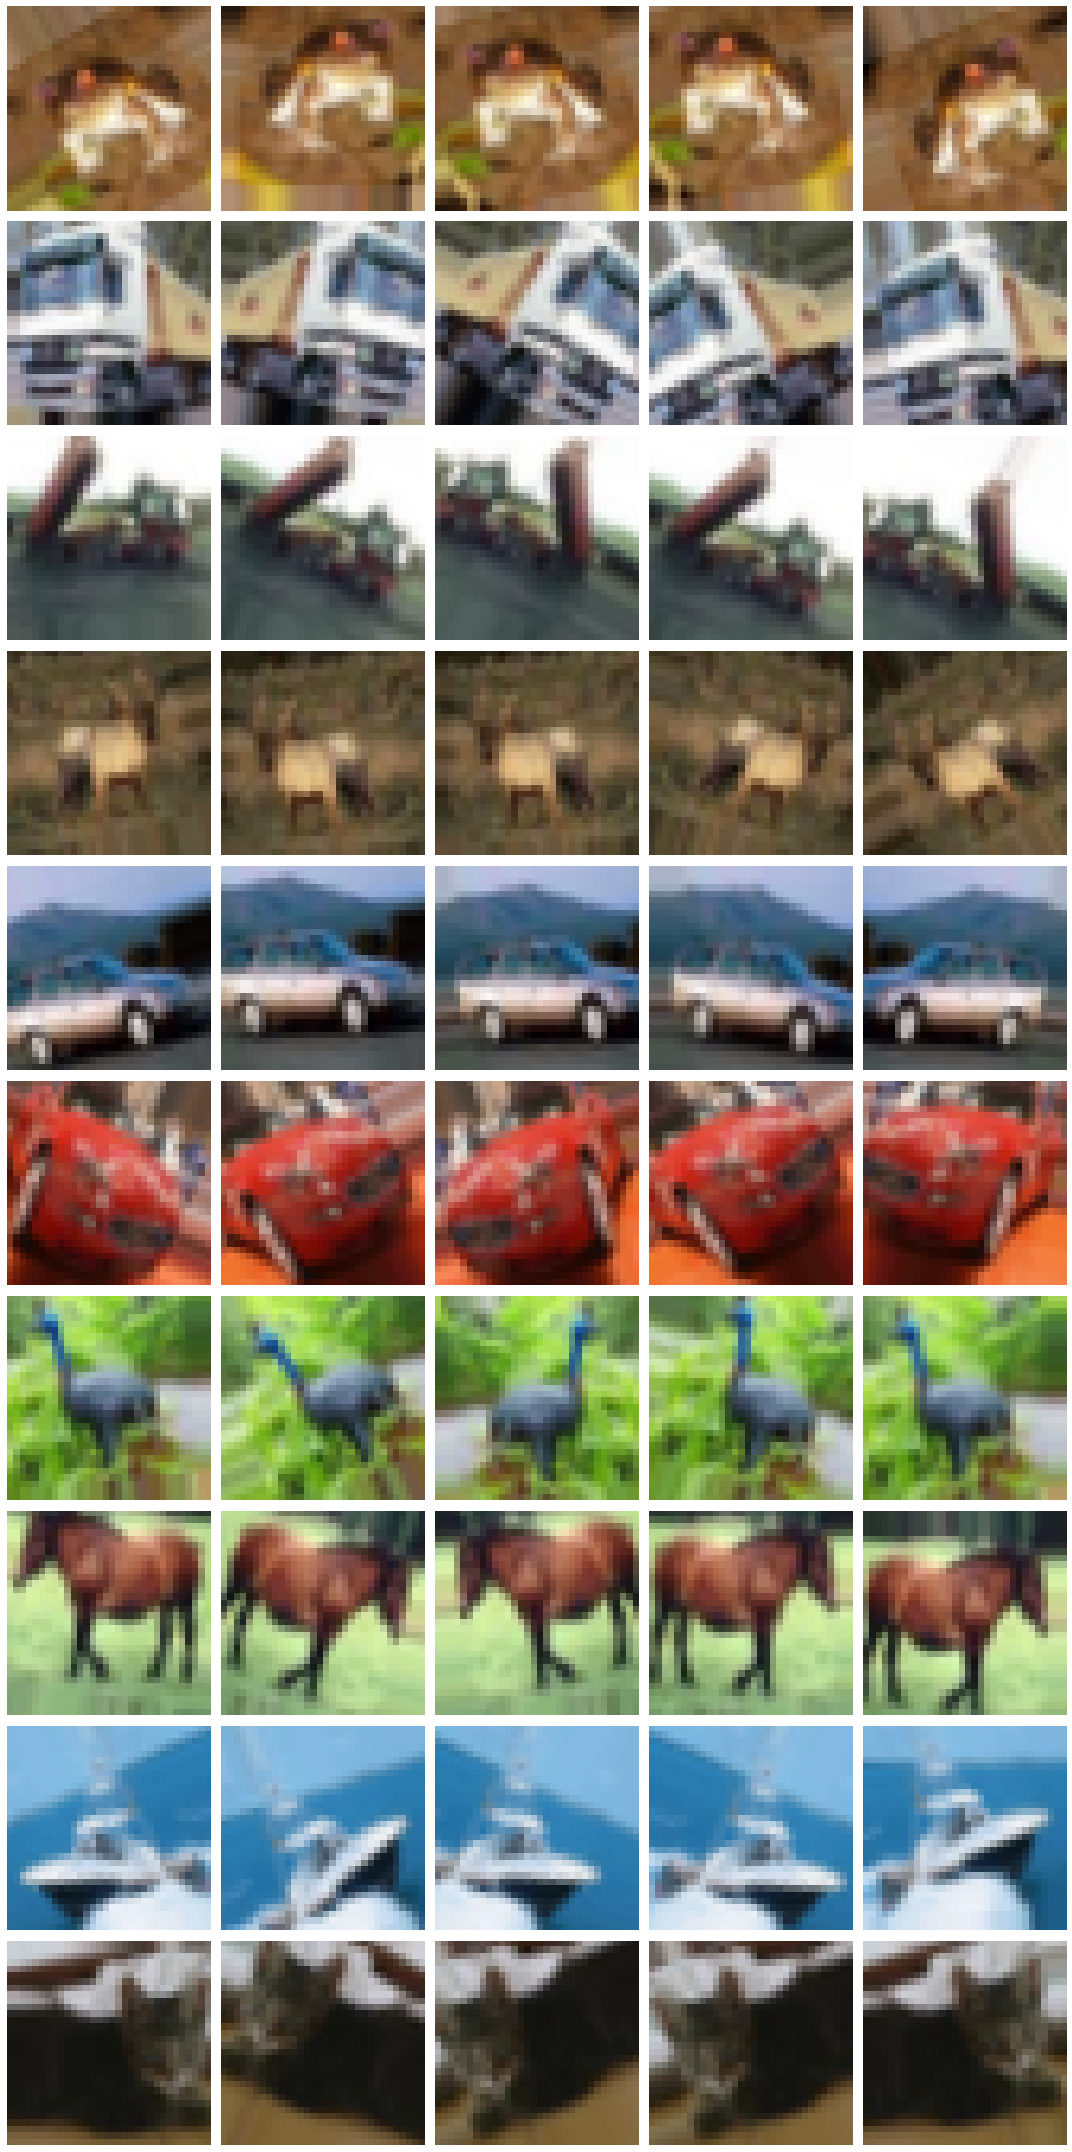

In [170]:
x_samples = X_train[:10]  

fig, axes = plt.subplots(10, 5, figsize=(15, 30)) 
axes = axes.flatten()

for i in range(10):
    for j in range(5):
        augmented_img = next(train_datagen.flow(x_samples[i:i+1], batch_size=1))
        ax_idx = i * 5 + j 
        axes[ax_idx].imshow(augmented_img[0], aspect='auto')
        axes[ax_idx].axis('off')

plt.tight_layout()
plt.show()

In [75]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
X_train = train_images.astype('float32') / 255
X_test = test_images.astype('float32') / 255
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [77]:
unique_labels, counts = np.unique(y_val, axis=0, return_counts=True)
number_of_unique_labels = unique_labels.shape[0]

print("Liczba unikalnych kombinacji etykiet w y_val:", number_of_unique_labels)
print("Rozkład klas w y_val:")
for label, count in zip(unique_labels, counts):
    print("Etykieta:", label, "Liczba wystąpień:", count)

Liczba unikalnych kombinacji etykiet w y_val: 10
Rozkład klas w y_val:
Etykieta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] Liczba wystąpień: 1000
Etykieta: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] Liczba wystąpień: 1000


In [78]:
import numpy as np

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = len(X_train)
augmented_images = []
augmented_labels = []

for _ in range(1):
    iterator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=False)
    aug_images, aug_labels = next(iterator)
    augmented_images.append(aug_images)
    augmented_labels.append(aug_labels)

augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

X_train_aug = np.concatenate([X_train, augmented_images])
y_train_aug = np.concatenate([y_train, augmented_labels])

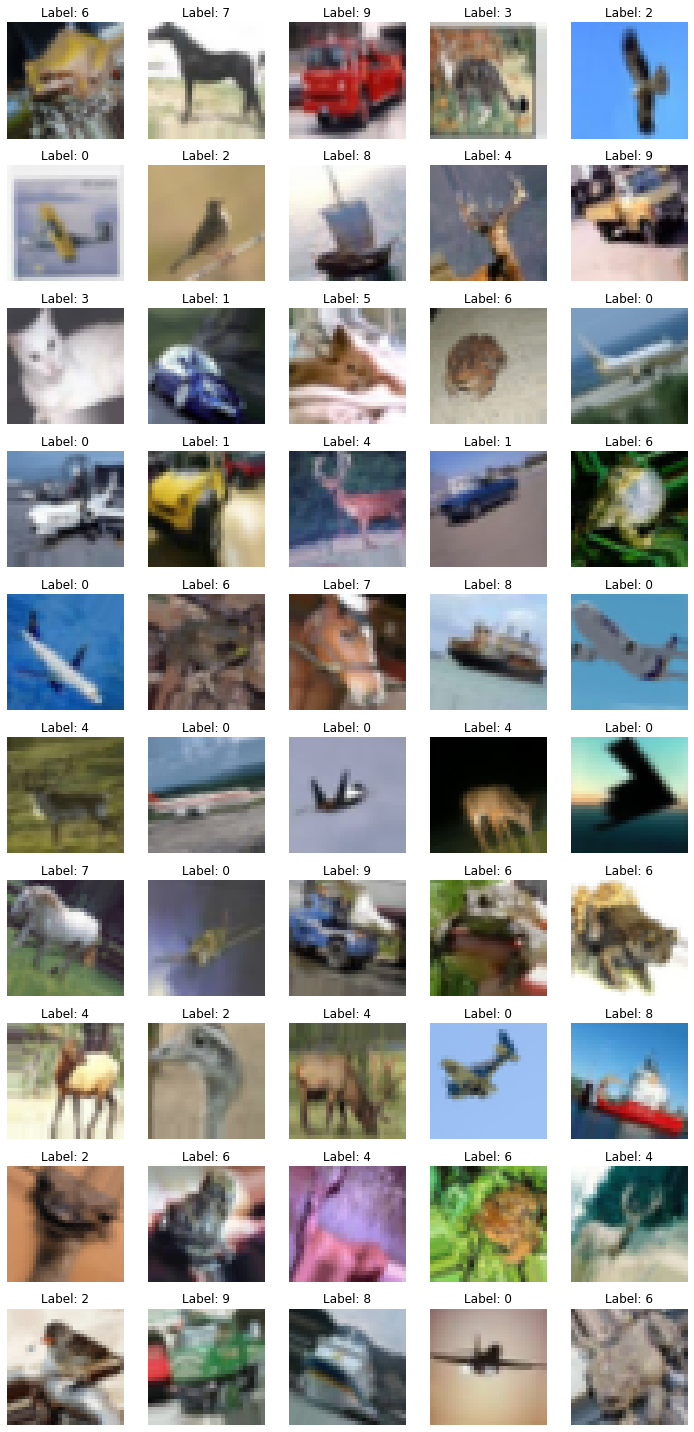

In [79]:
def display_images(images, labels, rows, cols):
    """Wyświetla obrazy wraz z etykietami w siatce o określonych wymiarach."""
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # Spłaszczanie listy osi do jednowymiarowej, aby łatwiej było iterować

    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)
        ax.set_title("Label: {}".format(label))  # Dodawanie etykiet jako tytułów nad obrazami
        ax.axis('off')  # Wyłączenie osi

    plt.tight_layout()  # Zapewnienie odpowiedniego rozmieszczenia subplots
    plt.show()

# Przykład użycia funkcji
sample_images = X_train_aug[-50:]  # Zakładając, że 'augmented_images' jest wcześniej zdefiniowane

# Zakładając, że masz etykiety jako one-hot encoding i chcesz je przekonwertować na etykiety klas
sample_labels = np.argmax(y_train_aug[-50:], axis=1)  # Dopasuj indeksy etykiet do obrazów

display_images(sample_images, sample_labels, 10, 5)  # 10 wierszy i 5 kolumn


In [80]:
y_train_aug[-100:]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 

In [81]:
display_images(X_train_aug[-100:], 10, 5)

TypeError: display_images() missing 1 required positional argument: 'cols'

In [ ]:
print("Shape of X_train_aug", X_train_aug.shape)
print("Shape of y_train_aug", y_train_aug.shape)
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)
unique, counts = np.unique(y_val, return_counts=True)
print(dict(zip(unique, counts)))

In [69]:
def create_model():
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_with_aug = create_model()
model_without_aug = create_model()

In [82]:
def create_model():
    model = Sequential([

    (Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3))),
    (BatchNormalization()),
    (Conv2D(32, (3,3), padding='same', activation='relu')),
    (BatchNormalization()),
    (MaxPool2D(pool_size=(2,2))),
    (Dropout(0.3)),

    (Conv2D(64, (3,3), padding='same', activation='relu')),
    (BatchNormalization()),
    (Conv2D(64, (3,3), padding='same', activation='relu')),
    (BatchNormalization()),
    (MaxPool2D(pool_size=(2,2))),
    (Dropout(0.5)),

    (Conv2D(128, (3,3), padding='same', activation='relu')),
    (BatchNormalization()),
    (Conv2D(128, (3,3), padding='same', activation='relu')),
    (BatchNormalization()),
    (MaxPool2D(pool_size=(2,2))),
    (Dropout(0.5)),

    (Flatten()),
    (Dense(128, activation='relu')),
    (BatchNormalization()),
    (Dropout(0.5)),
    (Dense(10, activation='softmax'))

    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_with_aug = create_model()
model_without_aug = create_model()

In [83]:
len(X_train_aug)

80000

In [84]:
idx = [i for i in range(len(X_train_aug))]
import random

random.shuffle(idx)
X_train_aug_shuffle = X_train_aug[idx]
y_train_aug_shuffle = y_train_aug[idx]

In [86]:
history_aug = model_with_aug.fit(X_train_aug_shuffle, y_train_aug_shuffle, epochs=30, batch_size=64, validation_data=(X_val, y_val))

history_dict_aug = history_aug.history
with open('training_history_aug.json', 'w') as f:
    json.dump(history_dict_aug, f)

Epoch 1/30
1250/1250 [==============================] - 489s 391ms/step - loss: 1.1273 - accuracy: 0.6017 - val_loss: 0.9447 - val_accuracy: 0.6666
Epoch 2/30
1250/1250 [==============================] - 502s 401ms/step - loss: 0.9840 - accuracy: 0.6574 - val_loss: 0.7195 - val_accuracy: 0.7454
Epoch 3/30
1250/1250 [==============================] - 454s 363ms/step - loss: 0.8984 - accuracy: 0.6870 - val_loss: 0.7092 - val_accuracy: 0.7516
Epoch 4/30
1250/1250 [==============================] - 451s 361ms/step - loss: 0.8337 - accuracy: 0.7128 - val_loss: 0.7385 - val_accuracy: 0.7468
Epoch 5/30
1250/1250 [==============================] - 452s 362ms/step - loss: 0.7833 - accuracy: 0.7304 - val_loss: 0.5927 - val_accuracy: 0.7970
Epoch 6/30
1250/1250 [==============================] - 453s 363ms/step - loss: 0.7443 - accuracy: 0.7464 - val_loss: 0.5514 - val_accuracy: 0.8113
Epoch 7/30
1250/1250 [==============================] - 453s 363ms/step - loss: 0.7149 - accuracy: 0.7561 - val_

In [87]:
history_no_aug = model_without_aug.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

history_dict_no_aug = history_no_aug.history
with open('training_history_no_aug.json', 'w') as f:
    json.dump(history_dict_no_aug, f)

Epoch 1/30
625/625 [==============================] - 242s 381ms/step - loss: 1.8192 - accuracy: 0.3780 - val_loss: 1.5711 - val_accuracy: 0.4409
Epoch 2/30
625/625 [==============================] - 236s 378ms/step - loss: 1.2739 - accuracy: 0.5435 - val_loss: 1.2827 - val_accuracy: 0.5601
Epoch 3/30
625/625 [==============================] - 235s 377ms/step - loss: 1.0797 - accuracy: 0.6154 - val_loss: 1.2235 - val_accuracy: 0.5811
Epoch 4/30
625/625 [==============================] - 235s 377ms/step - loss: 0.9697 - accuracy: 0.6606 - val_loss: 0.8442 - val_accuracy: 0.6972
Epoch 5/30
625/625 [==============================] - 235s 376ms/step - loss: 0.8721 - accuracy: 0.6958 - val_loss: 0.8271 - val_accuracy: 0.7053
Epoch 6/30
625/625 [==============================] - 235s 376ms/step - loss: 0.8187 - accuracy: 0.7151 - val_loss: 0.8047 - val_accuracy: 0.7215
Epoch 7/30
625/625 [==============================] - 235s 377ms/step - loss: 0.7626 - accuracy: 0.7340 - val_loss: 0.6827 -

Model WITHOUT images augmentation


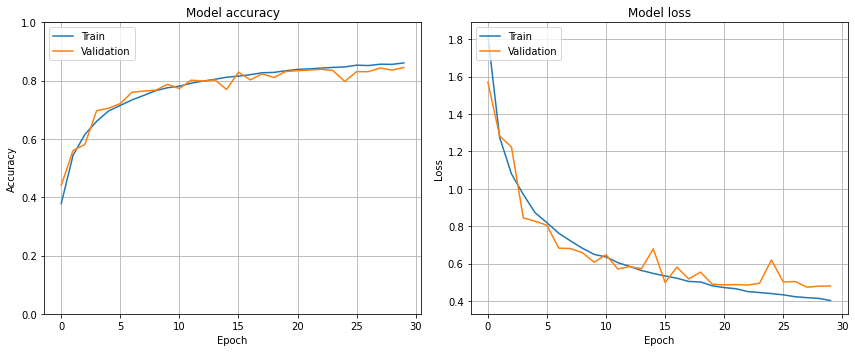

Accuracy on test set: 84.25
1250/1250 [==============================] - 59s 47ms/step - loss: 0.2062 - accuracy: 0.9298
Accuracy on train set: 92.98
Model WITH images augmentation


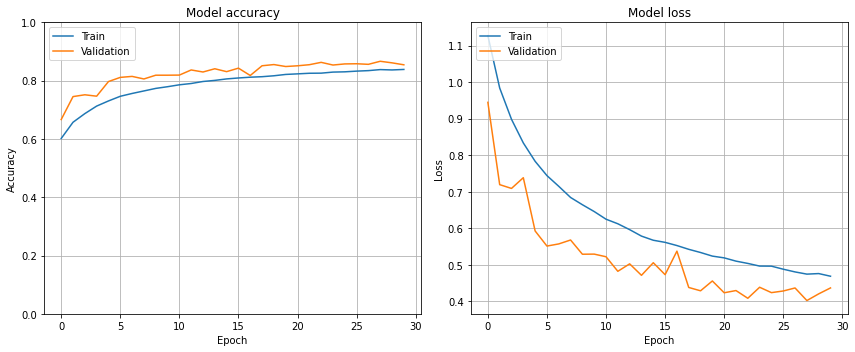

Accuracy on test set: 84.68
2500/2500 [==============================] - 125s 50ms/step - loss: 0.2896 - accuracy: 0.8993
Accuracy on train set: 89.93


In [92]:
print("Model WITHOUT images augmentation")
test_model(model_without_aug, X_test, y_test, 'training_history_no_aug.json', X_train, y_train)
print("Model WITH images augmentation")
test_model(model_with_aug, X_test, y_test, 'training_history_aug.json', X_train_aug, y_train_aug)

In [ ]:
def create_model2():
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_with_aug = create_model2()
model_without_aug = create_model2()

In [ ]:
history_aug = model_with_aug.fit(X_train_aug_shuffle, y_train_aug_shuffle, epochs=30, batch_size=64, validation_data=(X_val, y_val))

history_dict_aug = history_aug.history
with open('training_history_aug.json', 'w') as f:
    json.dump(history_dict_aug, f)

In [ ]:
history_no_aug = model_without_aug.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

history_dict_no_aug = history_no_aug.history
with open('training_history_no_aug.json', 'w') as f:
    json.dump(history_dict_no_aug, f)

In [ ]:
print("Model WITHOUT images augmentation")
test_model(model_without_aug, X_test, y_test, 'training_history_no_aug.json', X_train2, y_train2)
print("Model WITH images augmentation")
test_model(model_with_aug, X_test, y_test, 'training_history_aug.json', X_train2, y_train2)

In [139]:
history_aug = model_with_aug.fit(datagen.flow(X_train2, y_train2, batch_size=64), epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train2) // 64)

Epoch 1/10
625/625 [==============================] - 152s 244ms/step - loss: 1.3048 - accuracy: 0.5354 - val_loss: 1.1816 - val_accuracy: 0.5883
Epoch 2/10
 23/625 [>.............................] - ETA: 2:12 - loss: 1.2001 - accuracy: 0.5700

KeyboardInterrupt: 

# Other image modifications

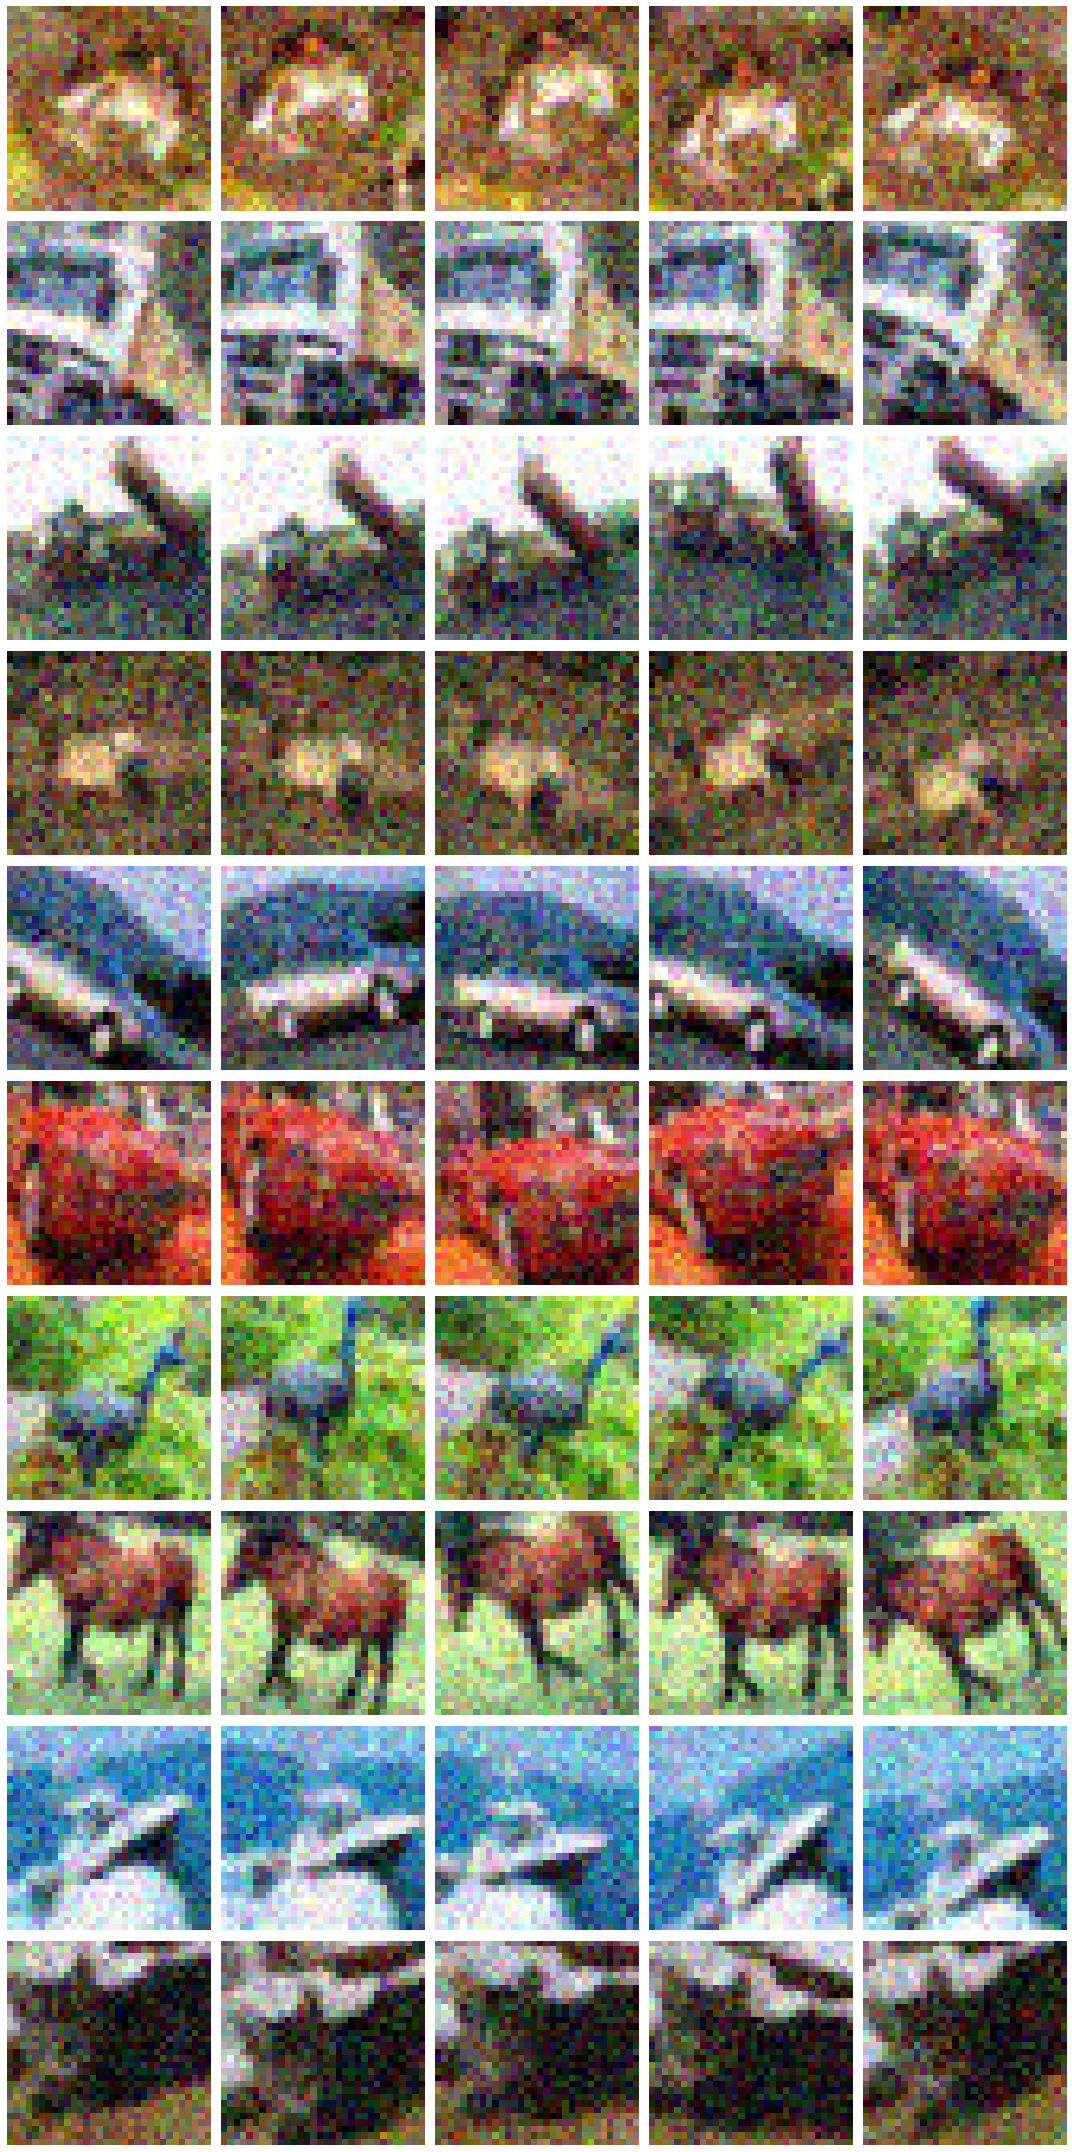

In [174]:
def add_noise(img):
    '''Dodaje losowy szum Gaussa do obrazu.'''
    mean, var = 0.01, 0.01
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, img.shape)  # tworzenie szumu
    noisy_img = img + gaussian  # dodanie szumu do obrazu
    noisy_img = np.clip(noisy_img, 0, 1)  # ograniczenie wartości do zakresu [0, 1]
    return noisy_img

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=add_noise 
)

train_datagen.fit(X_train)

x_samples = X_train[:10]  

fig, axes = plt.subplots(10, 5, figsize=(15, 30)) 
axes = axes.flatten()

for i in range(10):
    for j in range(5):
        augmented_img = next(train_datagen.flow(x_samples[i:i+1], batch_size=1))
        ax_idx = i * 5 + j 
        axes[ax_idx].imshow(augmented_img[0], aspect='auto')
        axes[ax_idx].axis('off')

plt.tight_layout()
plt.show()

Epoch 1/10
625/625 [==============================] - 93s 148ms/step - loss: 1.5382 - accuracy: 0.4412 - val_loss: 1.2507 - val_accuracy: 0.5686
Epoch 2/10
625/625 [==============================] - 92s 147ms/step - loss: 1.1948 - accuracy: 0.5789 - val_loss: 1.1306 - val_accuracy: 0.6044
Epoch 3/10
625/625 [==============================] - 94s 150ms/step - loss: 1.0495 - accuracy: 0.6346 - val_loss: 1.0375 - val_accuracy: 0.6413
Epoch 4/10
625/625 [==============================] - 93s 148ms/step - loss: 0.9666 - accuracy: 0.6645 - val_loss: 0.9277 - val_accuracy: 0.6789
Epoch 5/10
625/625 [==============================] - 92s 146ms/step - loss: 0.9005 - accuracy: 0.6868 - val_loss: 0.9021 - val_accuracy: 0.6915
Epoch 6/10
625/625 [==============================] - 92s 148ms/step - loss: 0.8379 - accuracy: 0.7073 - val_loss: 0.9172 - val_accuracy: 0.6822
Epoch 7/10
625/625 [==============================] - 92s 147ms/step - loss: 0.7910 - accuracy: 0.7236 - val_loss: 0.8828 - val_ac

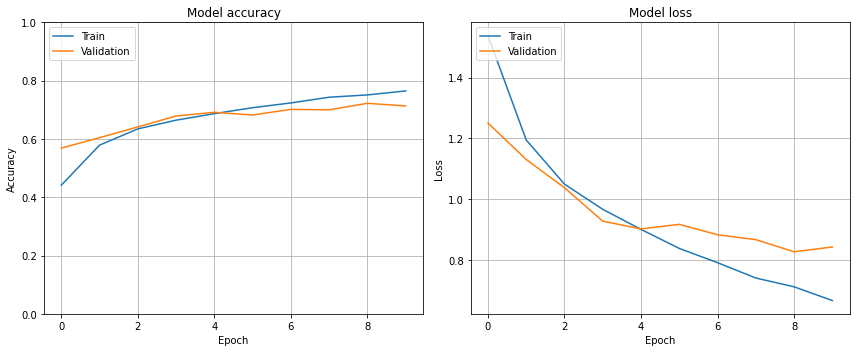

Accuracy on test set: 71.63
1250/1250 [==============================] - 24s 19ms/step - loss: 0.5191 - accuracy: 0.8286
Accuracy on train set: 82.86
Model WITH images augmentation


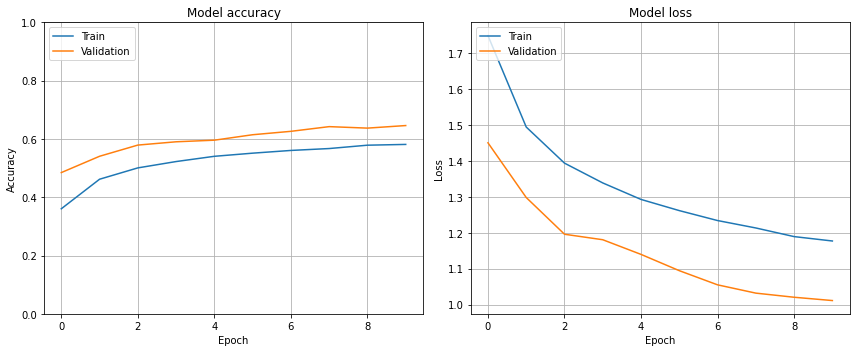

Accuracy on test set: 65.29
1250/1250 [==============================] - 24s 19ms/step - loss: 0.9280 - accuracy: 0.6740
Accuracy on train set: 67.40


In [175]:
def create_model():
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_with_aug = create_model()
model_without_aug = create_model()

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=add_noise )


history_no_aug = model_without_aug.fit(X_train2, y_train2, epochs=10, batch_size=64, validation_data=(X_val, y_val))
history_aug = model_with_aug.fit(datagen.flow(X_train2, y_train2, batch_size=64), epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train2) // 64)

history_dict_no_aug = history_no_aug.history
with open('training_history_no_aug_noise.json', 'w') as f:
    json.dump(history_dict_no_aug, f)

history_dict_aug = history_aug.history
with open('training_history_aug_noise.json', 'w') as f:
    json.dump(history_dict_aug, f)

print("Model WITHOUT images augmentation")
test_model(model_without_aug, X_test, y_test, 'training_history_no_aug_noise.json', X_train2, y_train2)
print("Model WITH images augmentation")
test_model(model_with_aug, X_test, y_test, 'training_history_aug_noise.json', X_train2, y_train2)

Model WITHOUT images augmentation


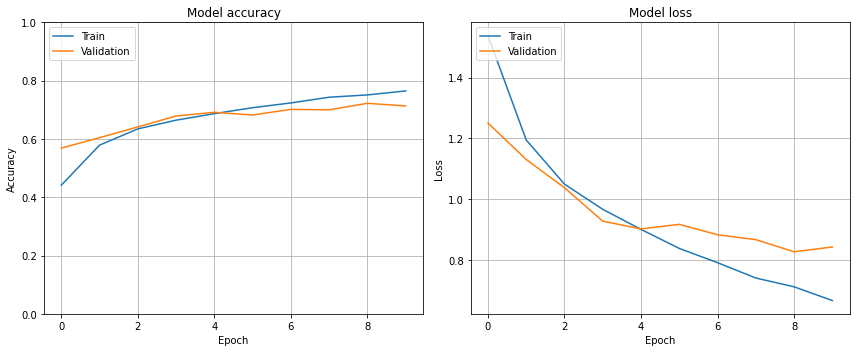

Accuracy on test set: 71.63
1250/1250 [==============================] - 26s 20ms/step - loss: 0.5191 - accuracy: 0.8286
Accuracy on train set: 82.86
Model WITH images augmentation


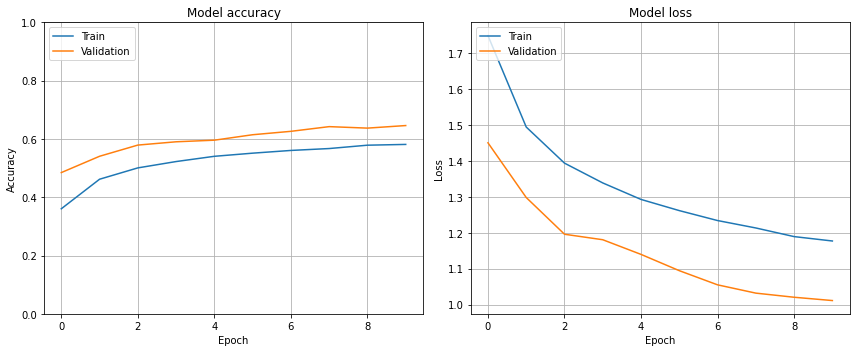

Accuracy on test set: 65.29
1250/1250 [==============================] - 24s 19ms/step - loss: 0.9280 - accuracy: 0.6740
Accuracy on train set: 67.40


In [176]:
print("Model WITHOUT images augmentation")
test_model(model_without_aug, X_test, y_test, 'training_history_no_aug_noise.json', X_train2, y_train2)
print("Model WITH images augmentation")
test_model(model_with_aug, X_test, y_test, 'training_history_aug_noise.json', X_train2, y_train2)

In [177]:
X_train2.size

122880000